In [1]:
import IPython
import IPython.display
import os

import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import LSTM, LeakyReLU ,Flatten , Dense, Dropout

import matplotlib.pyplot as plt
from profiling import cumTimer

In [2]:
print(tf.__version__)

2.6.0


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
tf.test.is_built_with_cuda()

3 Physical GPUs, 3 Logical GPUs


True

# Import Data

In [4]:
InputData = np.genfromtxt('Data/InputData.csv',delimiter=",")
t = np.genfromtxt('Data/time.csv',delimiter=",")
Data = np.genfromtxt('Data/OutputData.csv',delimiter=",")
print(f"OutData: %s, \nInputData: %s, \nTime: %s" %(np.shape(Data),np.shape(InputData),np.shape(t)))

OutData: (1000, 1000), 
InputData: (1000, 4), 
Time: (1000,)


# Split The Data

In [5]:
n = Data.shape[1]
train_df = Data[:, 0:int(n*0.7):]
val_df = Data[:,int(n*0.7):int(n*0.9):]
test_df = Data[:,int(n*0.9):]

num_features = Data.shape[1]


# Normalize Data

In [6]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

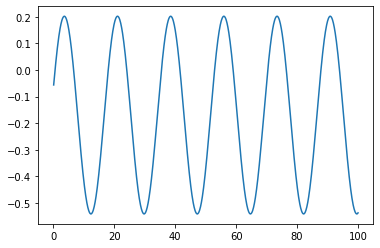

In [41]:
example_ind = 35
plt.plot(t,val_df[:,example_ind])


# Data Windowing

In [8]:
from window import WindowGenerator

Total window size: 60
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
Label indices: [30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53
 54 55 56 57 58 59]

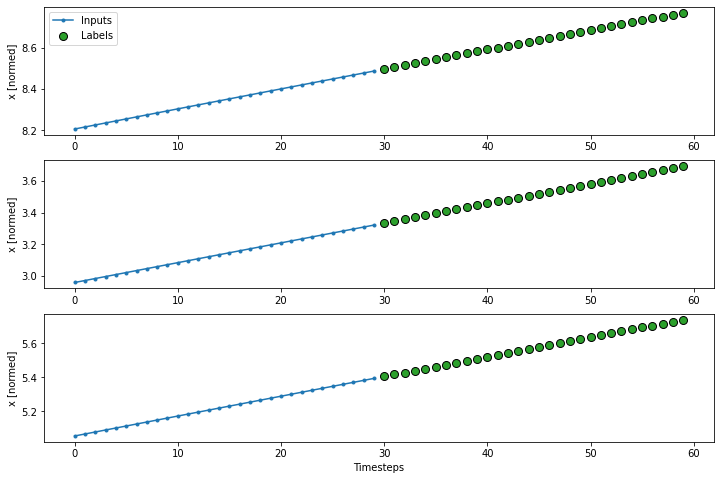

In [10]:
OUT_STEPS = 30
multi_window = WindowGenerator(input_width=30,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS,
                               train_df=train_df,
                               val_df=val_df,
                               test_df=test_df,
                               batch_size = 5000)

multi_window.plotexample()
multi_window

# FeedBack Model

In [11]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units

        self.l1 = LSTM(units, activation='tanh', return_sequences=True,return_state=True,name = "LSTM1")
        self.l2 = Dropout(0.2)
        self.l3 = LSTM(units, activation='tanh', return_sequences=True,return_state=True,name = "LSTM2")
        self.l4 = Dropout(0.2)
        self.l5 = Flatten(name = "Flat")
        self.l6 = Dense(units,activation=None, use_bias=True,name="Dense1")
        self.l7 = LeakyReLU(alpha=0.4,name = "LR3")
        self.l8 = Dense(units=1,name="Output")

    def warmup(self, inputs):
        inp = inputs                                 #Input        => inputs.shape      => (batch, time, features)
        x, *carry_state1 = self.l1(inp)              #LSTM 1       => x.shape           => (batch, timesteps,lstm_units)
        x = self.l2(x)                               #LEAKY RELU 1 => x.shape           => (batch, timesteps,lstm_units)
        x, *carry_state2  = self.l3(x)               #LSTM_2       => x.shape           => (batch, timesteps,lstm_units)
        x = self.l4(x)                               #Leaky_ReLU_2 => x.shape           => (batch, timesteps,lstm_units)
        x = self.l5(x)                               #Flatten      => x.shape           => (batch, timesteps * lstm_units)
        x = self.l6(x)                               #Dense_1      => x.shape           => (batch, lstm_units)
        x = self.l7(x)                               #Leaky_ReLU_3 => x.shape           => (batch, lstm_units)
        prediction = self.l8(x)                      #Dense_2      => predictions.shape => (batch, 1)
        
        return prediction , carry_state1 ,carry_state2

    def call(self, inputs, training=None):
      # Use a TensorArray to capture dynamically unrolled outputs.
      predictions = inputs
      # Initialize the LSTM state.
      prediction, carry_state1, carry_state2 = self.warmup(inputs)
      # Insert the first prediction.
      predictions = tf.concat(axis=1, values = [predictions,tf.expand_dims(prediction,axis=2)]) # <<<< note the cast
      # Run the rest of the prediction steps.
      for n in range(1, self.out_steps):
        # Use the last prediction as input.
        inp = predictions[:,n:,:]
        # Execute one lstm step.
        x, *carry_state1 = self.l1(inp , initial_state= [*carry_state1],
                                                training=training) #LSTM
        x = self.l2(x) #LEAKY RELU
        x, *carry_state2 = self.l3(x, initial_state= [*carry_state2], 
                                                training=training) #LSTM
        x = self.l4(x) #LEAKY RELU
        x = self.l5(x) #FLATEN
        x = self.l6(x) #DENSE/
        x = self.l7(x) #LEAKY RELU
        prediction = self.l8(x) #DENSELOL

        predictions = tf.concat(axis=1, values = [predictions,tf.expand_dims(prediction,axis=2)]) # <<<< note the cast

      # predictions.shape => (time, batch, features)
      return predictions[:,-OUT_STEPS:,:]

In [12]:
model =  FeedBack(units=64, out_steps=OUT_STEPS)
model(multi_window.example[0]).shape

TensorShape([5000, 30, 1])

In [14]:
models = os.listdir("Models/")
print(models)
print(f"Models/{models[-1]}")

['LSTM_AR100_Dropout@50@08-01-2022-21:43.h5', 'LSTM@500@09-01-2022-02:58.h5', 'LSTM@500@09-01-2022-02:58.h5AR@5009-01-2022-03:08.h5', 'feedbackWeights.h5', 'LSTM@500@09-01-2022-04:02.h5', 'LSTM@500@16-01-2022-23:42.h5', 'LSTM_AR100_Dropout@50@17-01-2022-00:35.h5', 'LSTM_AR100_Dropout@50@17-01-2022-00:58.h5', 'LSTM_AR100_Dropout@50@17-01-2022-01:14.h5', 'LSTM_AR100_Dropout@50@17-01-2022-01:25.h5', 'LSTM_AR100_Dropout@50@17-01-2022-04:44.h5', 'feedbackWeights2.h5']
Models/feedbackWeights2.h5


In [15]:
model.load_weights(f"Models/{models[3]}")

# Plot Case

In [31]:
%%time
predictions = multi_window.CalcCase(val_df[:,20],t,model)

We had to execute 33 calls
Predicted 990 timesteps
CPU times: user 6.22 s, sys: 16.7 ms, total: 6.23 s
Wall time: 6.03 s


In [37]:
example_ind = 35

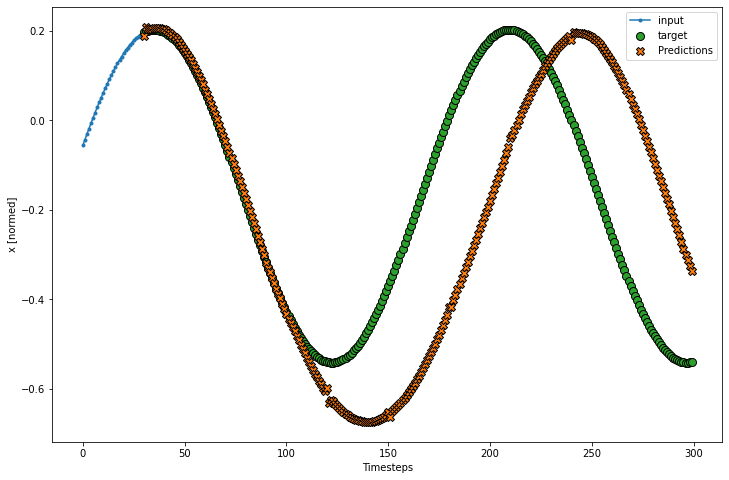

In [38]:
predictions = multi_window.plotCase(val_df[:,example_ind],t[:multi_window.input_width+multi_window.label_width*10],model)

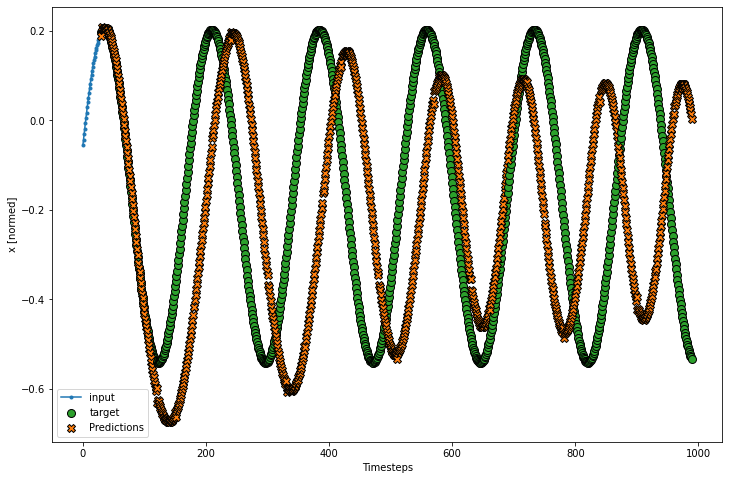

In [39]:
predictions = multi_window.plotCase(val_df[:,example_ind],t,model)

# Create Animation

In [17]:
from pltfigure import pltfigure
def AnimateDataset():
    predData = []
    for i in range(train_df.shape[1]):
        print("\nTest Case:{}".format(i))
        testCase = train_df[:,i]
        ts  = multi_window.CalcCase(testCase,multi_window,model)
        predData.append(ts)
    predData =np.array(predData)

    predData = np.array(predData)
    pltfigure(train_df.T,predData[:,:t.shape[0]],t,"Data","Prediction",'Graphs/datasetPredAR.gif')